## Annotation enrichemts
annotations done with VEP, checking to see if any annotaiton classes are enriched for pcqlts vs eqtls

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re

from tqdm.auto import tqdm  # for notebooks

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
annotations_output_dir = config['annotations_output_dir']
overlap_output_dir = config['overlap_output_dir']



# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])

# load data

In [3]:
# load in the data from all tissues
vep_dfs=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    sample_vep = pd.read_csv(f'{prefix}/{annotations_output_dir}/{tissue_id}.v8.leadvars.vep.vcf', skiprows=4, sep='\t')
    overlap_df = pd.read_csv(f'{prefix}/{overlap_output_dir}/{tissue_id}.v8.overlap.txt', sep='\t')
    vep_dfs.append(pd.merge(sample_vep, overlap_df, left_on='ID', right_on='lead_variant_id', how='outer'))

vep_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(vep_dfs, tissue_ids)])
vep_df['chr'] = 'chr' + vep_df['#CHROM'].astype(str)
vep_df.reset_index(inplace=True, drop=True)

In [4]:
# load in the gene information 
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]
full_gencode['transcript_type'] = full_gencode['info'].str.split(';').str[4].str.split('\"').str[-2]
full_gencode['transcript_id_short'] = full_gencode['transcript_id'].str.split('.').str[0]
full_gencode['tss_start'] = np.where(full_gencode['strand'] == '+', full_gencode['start'], full_gencode['end'])

gene_ids = np.concatenate(overlap_df['cluster_id'].str.split('_'))
gid_gencode = full_gencode.set_index('transcript_id').loc[gene_ids]
gid_gencode = gid_gencode.drop_duplicates()

### Bidirectional promotor
defined as tss with another tss less than 1000 bp away

In [144]:
# TODO should only be counted if this gene is expressed in this cell type
def is_bidirectional(row, gencode_df):
    is_close = (gencode_df['chr'] ==row['chr']) & (abs(gencode_df['tss_start']-row['tss_start'])<1000)
    is_opp_strand = (gencode_df['strand'] != row['strand'])
    return sum(is_close & is_opp_strand)>1

In [169]:
full_gencode['bidirectional_all'] = full_gencode.progress_apply(is_bidirectional, args=(full_gencode,), axis=1)
full_gencode['bidirectional_proteincoding'] = full_gencode.progress_apply(is_bidirectional, args=(full_gencode[full_gencode['transcript_type']=='protein_coding'],), axis=1)

  0%|          | 0/56200 [00:00<?, ?it/s]

KeyboardInterrupt: 

<AxesSubplot: xlabel='bidirectional_all', ylabel='Count'>

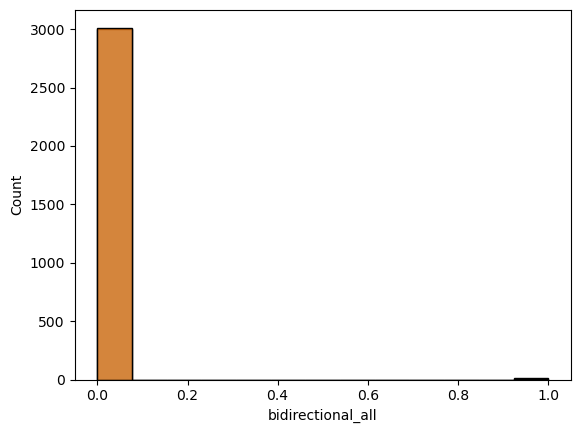

In [146]:
sns.histplot(gid_gencode['bidirectional_all'], label='all')
sns.histplot(gid_gencode['bidirectional_proteincoding'], label='proteincoding')

In [114]:
effect_list = pd.Series(row['INFO'].split(','))
sum(effect_list[['promoter' in e for e in effect_list]])
gene_ids = [p.split('|')[-11] for p in promoter_effects]
# I was going to check for matching gene ids, but vep gives my transcript ids and I have gids, 
# instead just check if it's withing 1kb of a promotor
r



In [153]:
sum(['promoter' in e for e in effect_list])


1

In [165]:
row=vep_df.iloc[0]

In [168]:
full_gencode[(full_gencode['chr'] == row['chr'])]

,chr,dataset,type,start,end,.,strand,na,info,transcript_id,transcript_type,transcript_id_short,tss_start
1,chr1,HAVANA,transcript,11869,14403,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN...",ENSG00000223972.5,transcribed_unprocessed_pseudogene,ENSG00000223972,11869
7,chr1,HAVANA,transcript,14410,29553,.,-,.,"gene_id ""ENSG00000227232.5""; transcript_id ""EN...",ENSG00000227232.5,unprocessed_pseudogene,ENSG00000227232,29553
20,chr1,ENSEMBL,transcript,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; transcript_id ""EN...",ENSG00000278267.1,miRNA,ENSG00000278267,17436
23,chr1,HAVANA,transcript,29571,31109,.,+,.,"gene_id ""ENSG00000243485.5""; transcript_id ""EN...",ENSG00000243485.5,lincRNA,ENSG00000243485,29571
29,chr1,HAVANA,transcript,34554,36081,.,-,.,"gene_id ""ENSG00000237613.2""; transcript_id ""EN...",ENSG00000237613.2,lincRNA,ENSG00000237613,36081
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41392,chr1,HAVANA,transcript,248850006,248859085,.,-,.,"gene_id ""ENSG00000171163.15""; transcript_id ""E...",ENSG00000171163.15,protein_coding,ENSG00000171163,248859085
41405,chr1,HAVANA,transcript,248859164,248864796,.,+,.,"gene_id ""ENSG00000227237.1""; transcript_id ""EN...",ENSG00000227237.1,antisense,ENSG00000227237,248859164
41410,chr1,HAVANA,transcript,248906196,248919946,.,+,.,"gene_id ""ENSG00000185220.11""; transcript_id ""E...",ENSG00000185220.11,protein_coding,ENSG00000185220,248906196
41416,chr1,ENSEMBL,transcript,248912690,248912795,.,-,.,"gene_id ""ENSG00000200495.1""; transcript_id ""EN...",ENSG00000200495.1,snRNA,ENSG00000200495,248912795


In [156]:
row['POS'] 

101235342

In [148]:
if sum(promoter_effects)>0:
    

SyntaxError: invalid syntax (935701890.py, line 1)

In [115]:
gene_ids

['ENST00000475821']

In [ ]:
# counts as bidirectional if vep had annotated it as in the promotor for one of those 

## VEP
vep annotates with variant categories

all the useful information is in the 'INFO' column:



Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS



* One info tags for each transcript the variant impacts, these are seperated by commas
* if an allele has multiple impacts on the same transcript, those appear to be listed with an &

In [5]:
# as an example
sample_vep.iloc[4].INFO

'CSQ=C|intron_variant|MODIFIER|ELAPOR1|ENSG00000116299|Transcript|ENST00000369939|protein_coding||1/21||||||||rs113212636||1||HGNC|HGNC:29618|ENST00000529753|0.0956|||||||||,C|upstream_gene_variant|MODIFIER|CFAP276|ENSG00000179902|Transcript|ENST00000369942|retained_intron||||||||||rs113212636|1447|-1||HGNC|HGNC:32331|ENST00000529753|0.0956|||||||||,C|upstream_gene_variant|MODIFIER|CFAP276|ENSG00000179902|Transcript|ENST00000369945|protein_coding||||||||||rs113212636|2535|-1||HGNC|HGNC:32331|ENST00000529753|0.0956|||||||||,C|upstream_gene_variant|MODIFIER|CFAP276|ENSG00000179902|Transcript|ENST00000369948|protein_coding||||||||||rs113212636|2535|-1||HGNC|HGNC:32331|ENST00000529753|0.0956|||||||||,C|upstream_gene_variant|MODIFIER|CFAP276|ENSG00000179902|Transcript|ENST00000369949|protein_coding||||||||||rs113212636|1425|-1||HGNC|HGNC:32331|ENST00000529753|0.0956|||||||||,C|intron_variant|MODIFIER|ELAPOR1|ENSG00000116299|Transcript|ENST00000457623|protein_coding||1/19||||||||rs113212636|

In [6]:
# a version with lists of the info fields, still only one row per cs
# I think this is better because, ie a variant would be listed as coding for each transcript its in, but I don't want to count each of those

def get_info_list(row, idx):
    return list(set([item.split('|')[idx] for item in row.INFO.split(',')]))

info_tags = 'Allele|Consequence|IMPACT|SYMBOL|Gene|Feature_type|Feature|BIOTYPE|EXON|INTRON|HGVSc|HGVSp|cDNA_position|CDS_position|Protein_position|Amino_acids|Codons|Existing_variation|DISTANCE|STRAND|FLAGS|SYMBOL_SOURCE|HGNC_ID|NEAREST|AF|CLIN_SIG|SOMATIC|PHENO|PUBMED|MOTIF_NAME|MOTIF_POS|HIGH_INF_POS|MOTIF_SCORE_CHANGE|TRANSCRIPTION_FACTORS'
info_tags = info_tags.split('|')

for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    vep_df[tag_name] = vep_df.apply(get_info_list, args=(i,), axis=1)

Allele


Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


In [7]:
# make a list of the tissues for each ID
tissue_list = vep_df.groupby('ID')['tissue_id'].apply(list)
vep_df['tissue_list'] = vep_df['ID'].map(tissue_list)

In [8]:
# vep df should not be deduplicated I think
# just be sure to keep the orig dataset in mind 
#vep_df = vep_df.drop_duplicates('ID')

In [9]:
# add pc num column
vep_df['pc_num'] = np.where(vep_df['cs_full_id'].str.contains('_pc'), vep_df['cs_full_id'].str.split('_').str[-2], 0)
vep_df['pc_num'] = np.where(vep_df['cs_full_id'].str.contains('_pc'), vep_df['pc_num'].str.strip('pc'), 0) 
vep_df['pc_num'] = vep_df['pc_num'].astype(int)

#### Consequence

In [11]:
# some conseqeunces have an '&' in their name if multiple consequnces are prediced for the variant on the same transcript. 
# I will split those

def split_consequence(row):
    return list(set([indv_c for c in row['Consequence'] for indv_c in c.split('&')]))

vep_df['consequence_set'] = vep_df.apply(split_consequence, axis=1)

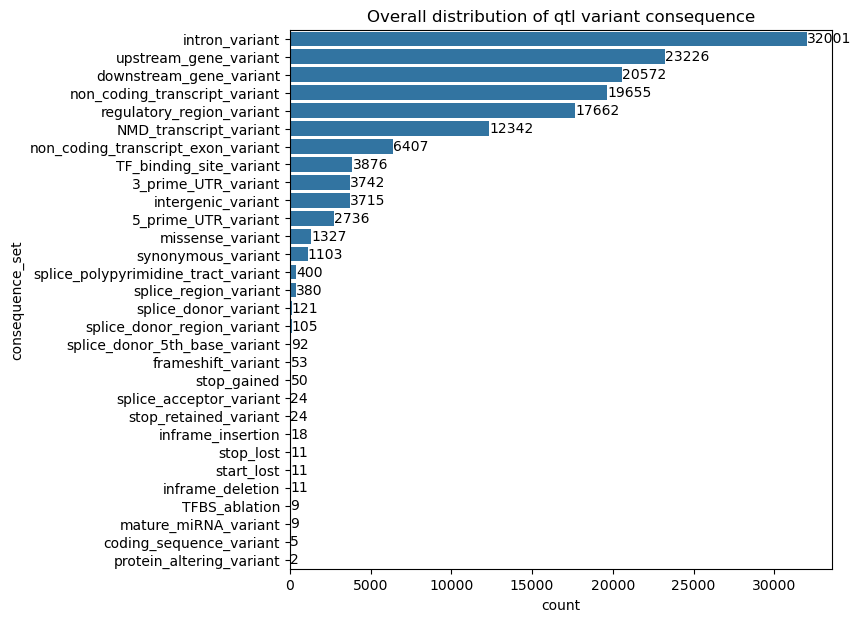

In [12]:
fig, ax = plt.subplots(figsize=(7,7))
ordered_c_categories = vep_df.explode('consequence_set')['consequence_set'].value_counts().index
y = sns.countplot(vep_df.explode('consequence_set'), y='consequence_set', ax=ax, order=ordered_c_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant consequence')
plt.show()

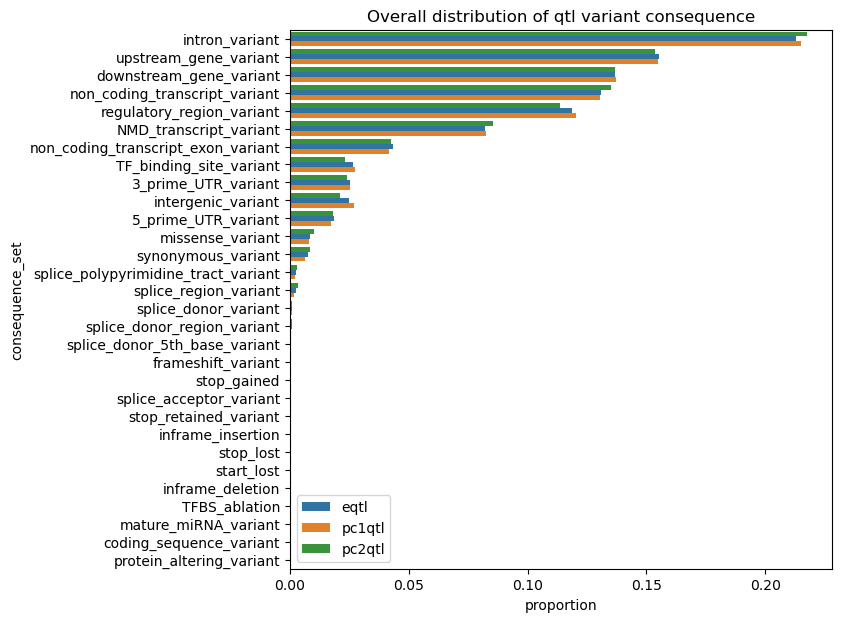

In [13]:
# bar graph with the number of things in each category for pcqtls and eqtls and with each dataset normed individually
fig, ax = plt.subplots(figsize=(7,7))
c_df = vep_df.explode('consequence_set')
datsets = vep_df['orig_cs_dataset'].unique()

labels = ['eqtl', 'pc1qtl', 'pc2qtl', 'pt3qtl']
for i in range(3):
    y = sns.countplot(c_df[c_df['pc_num']==i], y='consequence_set', ax=ax, order=ordered_c_categories, label=labels[i], stat='proportion')
    if i==0:
        for bar in y.patches:
            bar.set_y(bar.get_y() - bar.get_height()/3)
    elif i==1:
        for bar in y.patches:
            bar.set_y(bar.get_y() + 2*bar.get_height()/3)
plt.title('Overall distribution of qtl variant consequence')
for bar in y.patches:
    bar.set_height(bar.get_height()/3)
plt.show()

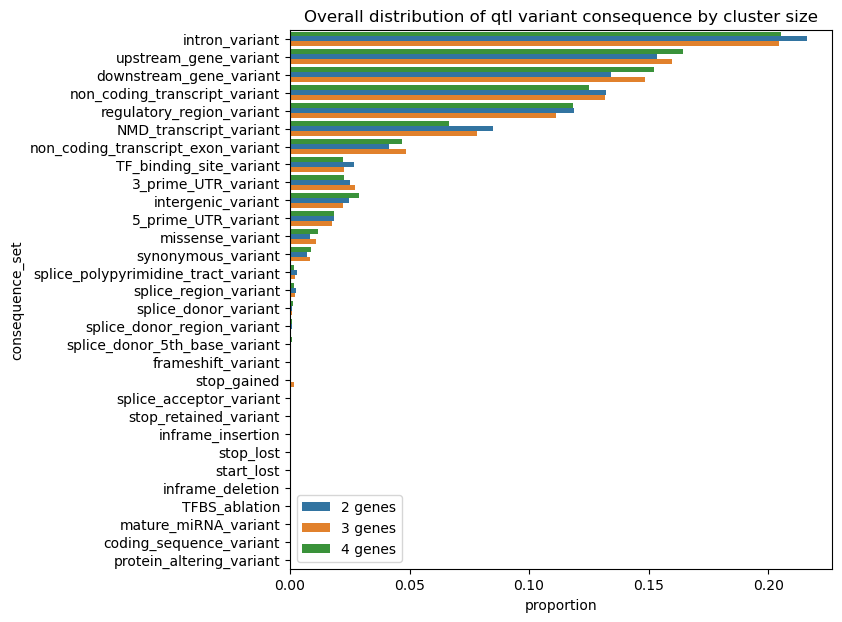

In [14]:
vep_df['cluster_size'] = vep_df['cluster_id'].str.split('_').apply(len)

c_df = vep_df.explode('consequence_set')

fig, ax = plt.subplots(figsize=(7,7))
ordered_c_categories = vep_df.explode('consequence_set')['consequence_set'].value_counts().index
for i in range(2,5):
    y = sns.countplot(c_df[c_df['cluster_size'].clip(2,4)==i], y='consequence_set', ax=ax, order=ordered_c_categories, label=f'{i} genes', stat='proportion')
    if i==2:
        for bar in y.patches:
            bar.set_y(bar.get_y() - bar.get_height()/3)
    elif i==3:
        for bar in y.patches:
            bar.set_y(bar.get_y() + 2*bar.get_height()/3)
plt.title('Overall distribution of qtl variant consequence by cluster size')
for bar in y.patches:
    bar.set_height(bar.get_height()/3)
plt.show()

##### log odds

In [15]:
# error bars on log odds come from error propegation for counts
def calculate_log_odds_error(counts1_positive, counts1_total, counts2_positive, counts2_total):
    counts1_negative = counts1_total-counts1_positive
    counts2_negative = counts2_total-counts2_positive

    # calculate the odds ratio
    or_ratio = (counts1_positive / counts1_negative) / (counts2_positive / counts2_negative)

    # calculate the standard error
    SE_log_OR = np.sqrt(1/counts1_positive - 1/counts1_negative + 1/counts2_positive - 1/counts2_negative)
    lower_bound, upper_bound = np.exp(np.log(or_ratio) - 1.96*SE_log_OR), np.exp(np.log(or_ratio) + 1.96*SE_log_OR)

    return np.log2(or_ratio), np.log2(lower_bound), np.log2(upper_bound)


def get_or_counts(vep_df, key_col='consequence_set'):
    return vep_df.explode(key_col).value_counts(key_col)

def get_odds_df(counts1, name1, counts2, name2, ordered_categories):
    or_df = pd.DataFrame({name1: counts1, name2: counts2})

    # add the odds ratios and 95% cis
    for idx in or_df.index:
        or_ratio, lower_bound, upper_bound = calculate_log_odds_error(or_df.loc[idx][name1], or_df[name1].sum(), or_df.loc[idx][name2], or_df[name2].sum())
        or_df.loc[idx, 'or_ratio'] = or_ratio
        or_df.loc[idx, 'lower_bound'] = lower_bound
        or_df.loc[idx, 'upper_bound'] = upper_bound

    or_df['upper_err_abs'] = or_df['upper_bound'] - or_df['or_ratio']
    or_df['lower_err_abs'] = or_df['or_ratio'] - or_df['lower_bound']
    return or_df.loc[ordered_categories[ordered_categories.isin(or_df.index)]].reset_index()

def plot_log_odds(or_df, title, key_col='consequence_set', ax=None, offset=-.2):
    if ax==None:
        fig, ax = plt.subplots(figsize=(7,7))
    # reset index to get consequence_set as a column

    ax.errorbar(y=or_df[key_col], x=or_df['or_ratio'], xerr=np.clip(or_df[['lower_err_abs', 'upper_err_abs']].values.transpose(), -3, 3), fmt="o")

    ax.invert_yaxis()
    plt.axvline(0, color='k')
    plt.text(.1, len(or_df)+offset, f'-> {or_df.columns[1]}')
    plt.text(-.1, len(or_df)+offset, f'{or_df.columns[2]} <-', horizontalalignment='right')
    plt.title(title)
    return ax

<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant consequences'}>

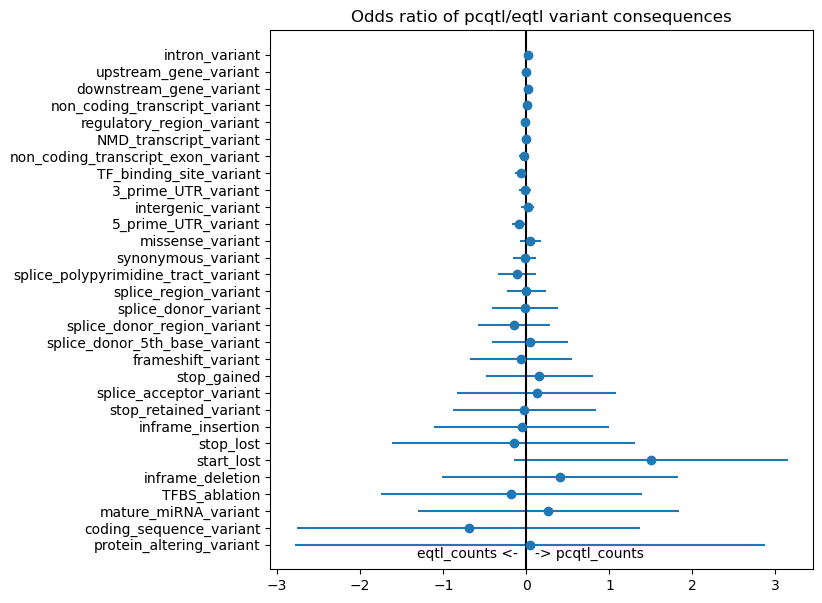

In [16]:
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['num_pc_samelead']>0)])
eqtl_counts = get_or_counts(vep_df[(vep_df['num_e_samelead']>0)])

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant consequences')

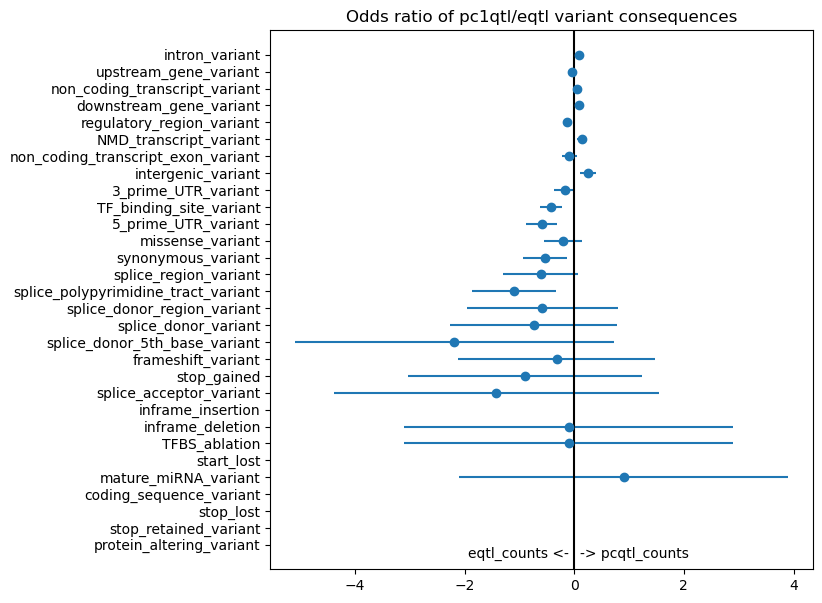

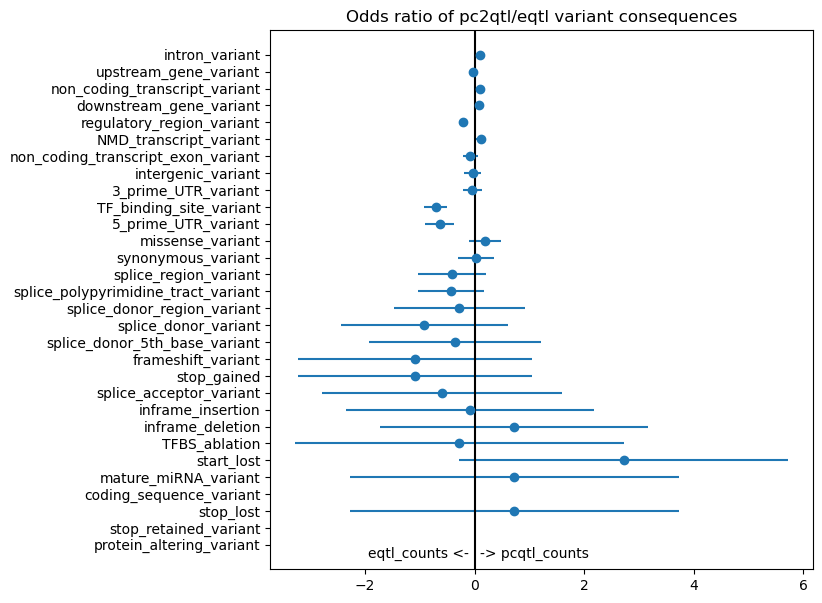

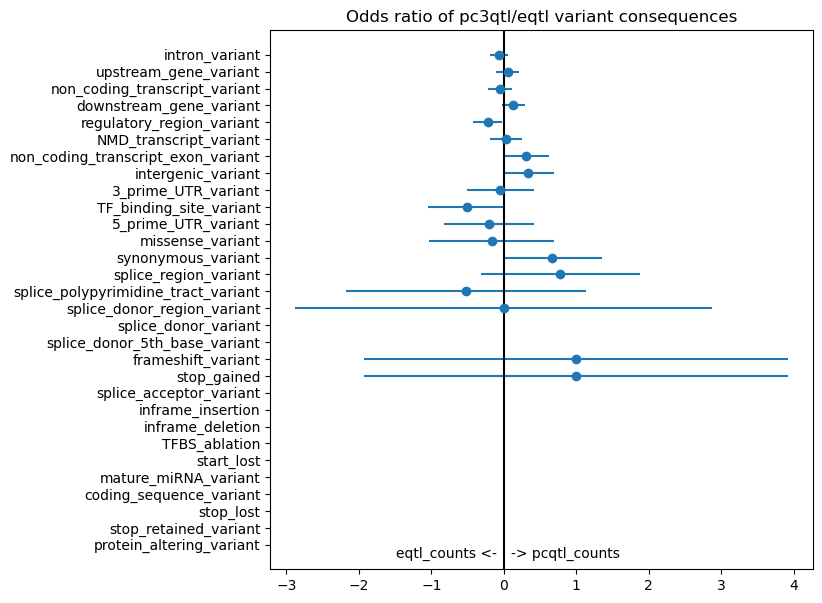

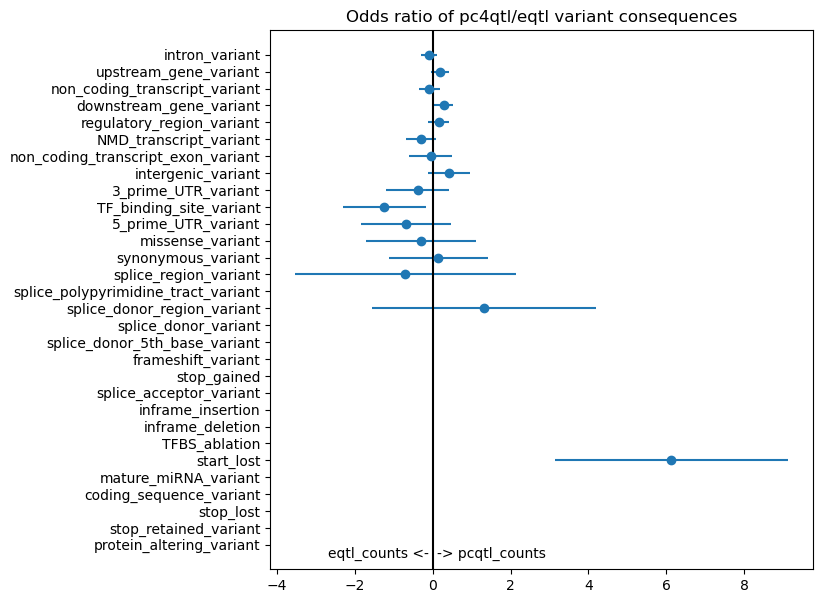

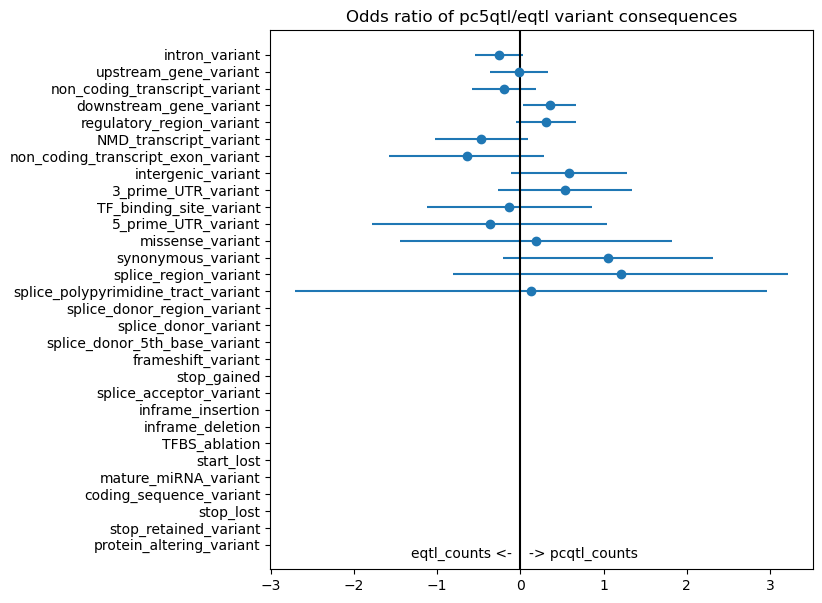

In [168]:
# get counts for pcqtl vs all eqtls for different pc nums
for i in range(5):
    pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==i+1)])
    eqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==0)])

    # format into a df and get the error bars
    or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_c_categories)

    # plot
    plot_log_odds(or_df, f'Odds ratio of pc{i+1}qtl/eqtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of pc1qtl/pc2qtl variant consequences'}>

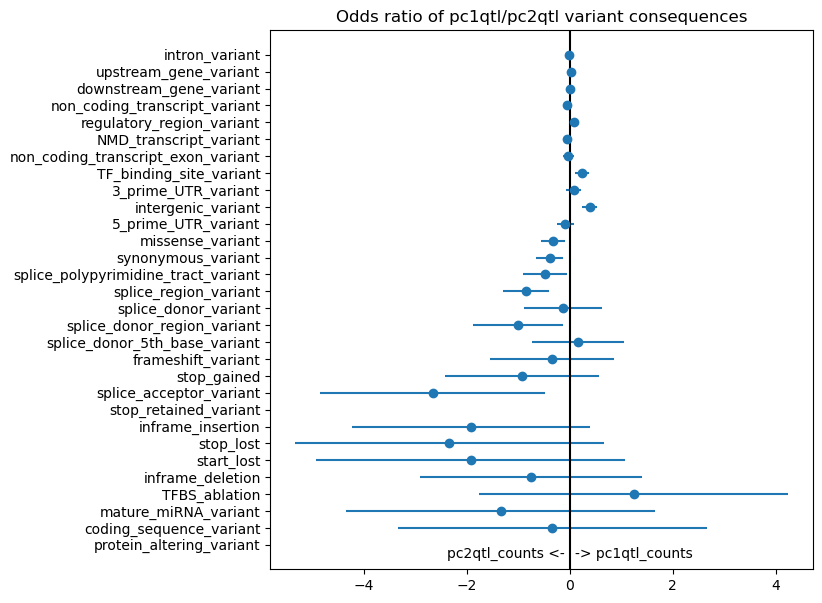

In [18]:
# get counts for all pc1qtl  vs pc2qtl
pc1qtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==1)])
pc2qtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==2)])

# format into a df and get the error bars
or_df = get_odds_df(pc1qtl_counts, 'pc1qtl_counts', pc2qtl_counts, 'pc2qtl_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pc1qtl/pc2qtl variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant consequences'}>

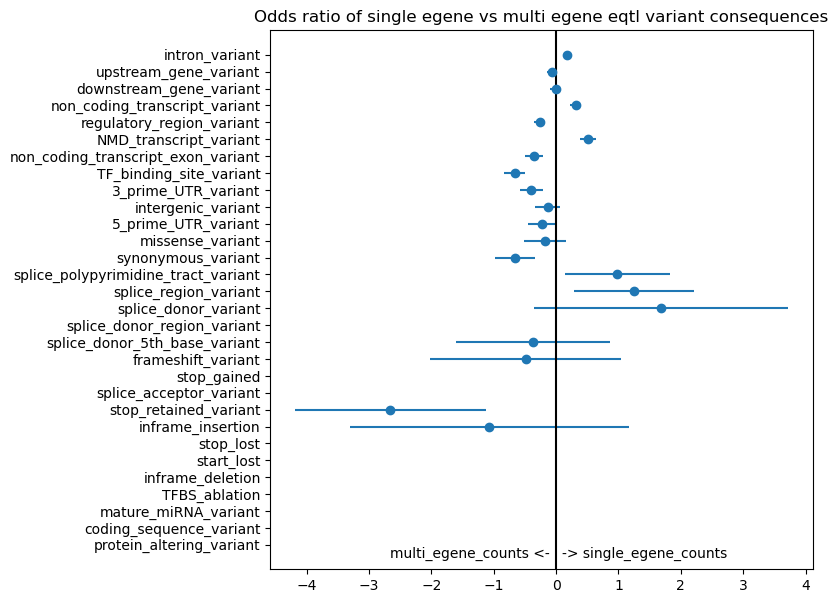

In [20]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)])
multi_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)])

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant consequences')

### better control group
have a set of eqtls from all genes on chr22 as a control

In [21]:
def get_lead_var(susie_df):
    return susie_df.loc[susie_df.groupby('cs_full_id')['pip'].idxmax(),['cs_full_id','variant_id']].set_index('cs_full_id')

In [22]:
control_veps=[]
for i in range(len(tissue_ids)):
    tissue_id = tissue_ids[i]
    control_vep = pd.read_csv(f'{prefix}/output/chr22_eqtl_annotations/{tissue_id}.v8.chr22_genes.leadvars.vep.vcf', skiprows=4, sep='\t')

    # get susie and groupby lead variant
    control_susie = pd.read_csv(f'{prefix}/output/chr22_eqtl/{tissue_id}/{tissue_id}.v8.chr22_genes.susie.txt', sep='\t', index_col=0)
    control_susie['cs_full_id'] = control_susie['phenotype_id'].astype(str) + '_e_cs' + control_susie['cs_id'].astype(str) 
    control_cs_df = pd.DataFrame(pd.Series(control_susie.groupby(['cs_full_id'])['variant_id'].apply(list), name='variant_list'))
    control_cs_df['lead_variant_id'] = get_lead_var(control_susie)

    # merge 
    control_veps.append(pd.merge(control_vep, control_cs_df, left_on='ID', right_on='lead_variant_id', how='outer'))


control_vep_df = pd.concat([df.assign(tissue_id=n) for df, n in zip(control_veps, tissue_ids)])
control_vep_df.reset_index(inplace=True, drop=True)

In [23]:
# split out info tags
for i in range(len(info_tags)):
    tag_name = info_tags[i]
    print(tag_name)
    control_vep_df[tag_name] = control_vep_df.apply(get_info_list, args=(i,), axis=1)

control_vep_df = control_vep_df.drop_duplicates('ID')
control_vep_df['consequence_set'] = control_vep_df.apply(split_consequence, axis=1)


Allele
Consequence
IMPACT
SYMBOL
Gene
Feature_type
Feature
BIOTYPE
EXON
INTRON
HGVSc
HGVSp
cDNA_position
CDS_position
Protein_position
Amino_acids
Codons
Existing_variation
DISTANCE
STRAND
FLAGS
SYMBOL_SOURCE
HGNC_ID
NEAREST
AF
CLIN_SIG
SOMATIC
PHENO
PUBMED
MOTIF_NAME
MOTIF_POS
HIGH_INF_POS
MOTIF_SCORE_CHANGE
TRANSCRIPTION_FACTORS


<AxesSubplot: title={'center': 'Odds ratio of cluster pcqtls/all eqtls variant consequences'}>

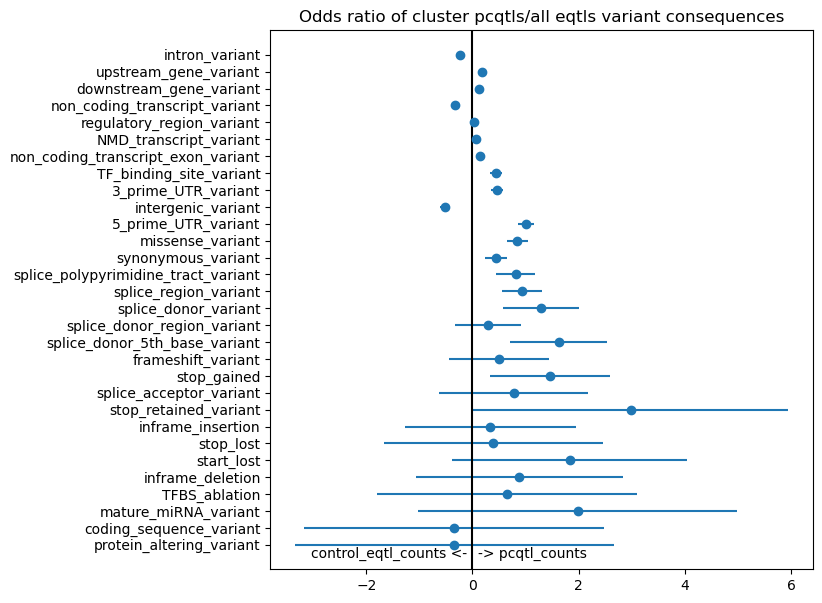

In [24]:
# get counts for all pcqtl vs background set of eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']>0)])
control_counts = get_or_counts(control_vep_df)

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', control_counts, 'control_eqtl_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of cluster pcqtls/all eqtls variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of exclusive cluster pcqtls/all eqtls variant consequences'}>

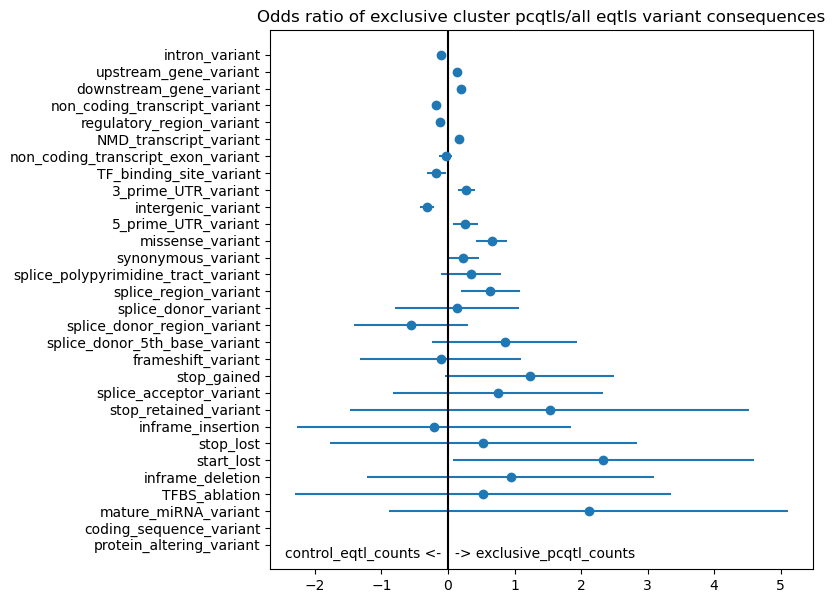

In [25]:
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']>0)&(vep_df['num_e_samelead']==0)])
control_counts = get_or_counts(control_vep_df)

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'exclusive_pcqtl_counts', control_counts, 'control_eqtl_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of exclusive cluster pcqtls/all eqtls variant consequences')

<AxesSubplot: title={'center': 'Odds ratio of cluster eqtls/all eqtls variant consequences'}>

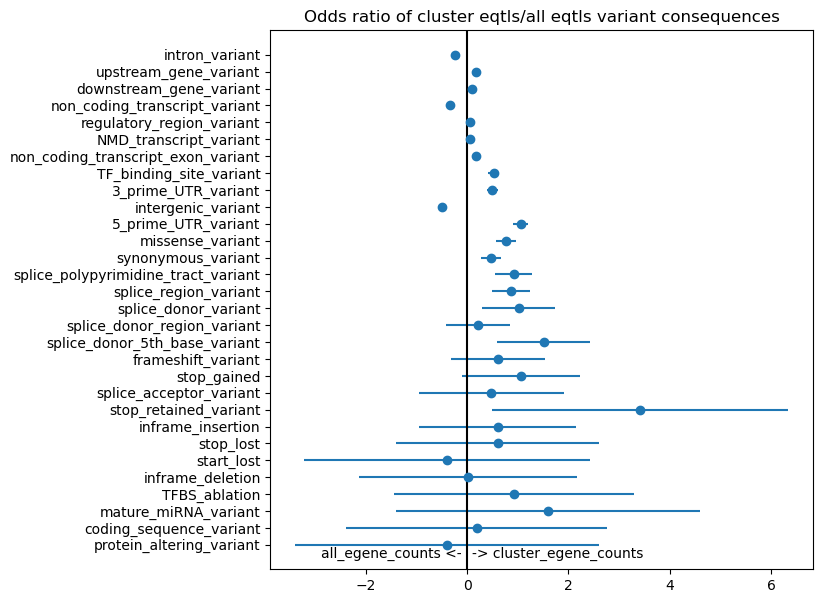

In [26]:
# get counts for all pcqtl svs all eqtls
cluster_egene_counts = get_or_counts(vep_df[(vep_df['pc_num']==0)])
all_egene_counts = get_or_counts(control_vep_df)

# format into a df and get the error bars
or_df = get_odds_df(cluster_egene_counts, 'cluster_egene_counts', all_egene_counts, 'all_egene_counts', ordered_categories=ordered_c_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of cluster eqtls/all eqtls variant consequences')

Text(0.5, 1.0, 'Cluster size distribution')

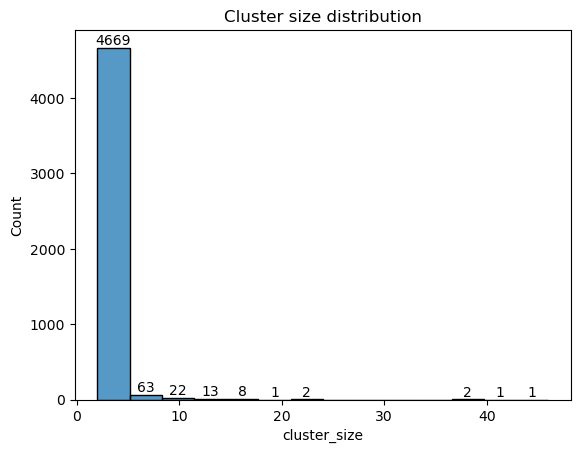

In [27]:
# split out by cluster size

y = sns.histplot(vep_df.drop_duplicates('cluster_id'), x='cluster_size')
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Cluster size distribution')

### Biotype

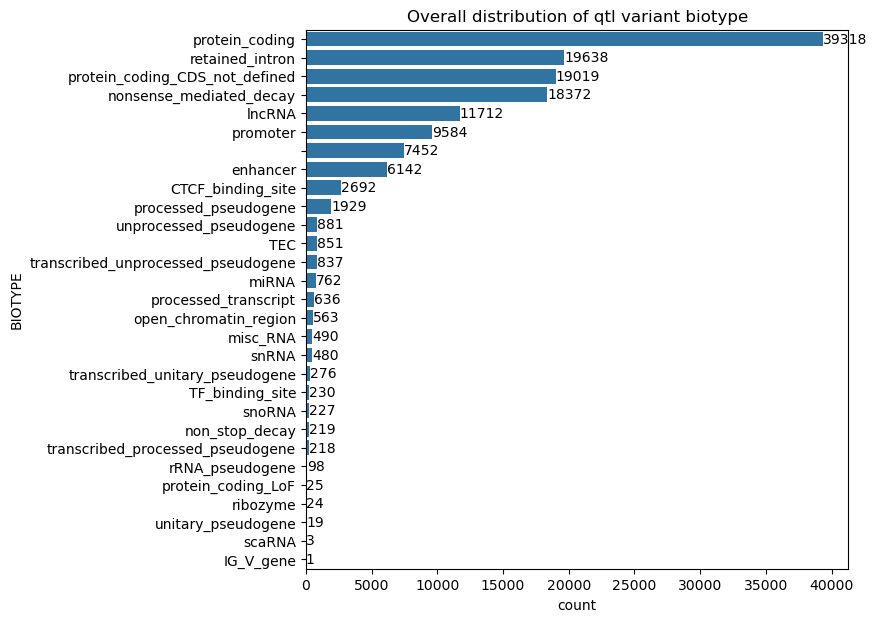

In [28]:
# overall distribution of biotype
fig, ax = plt.subplots(figsize=(7,7))
ordered_b_categories = vep_df.explode('BIOTYPE')['BIOTYPE'].value_counts().index
y = sns.countplot(vep_df.explode('BIOTYPE'), y='BIOTYPE', ax=ax, order=ordered_b_categories)
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of qtl variant biotype')
plt.show()

<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant biotype'}>

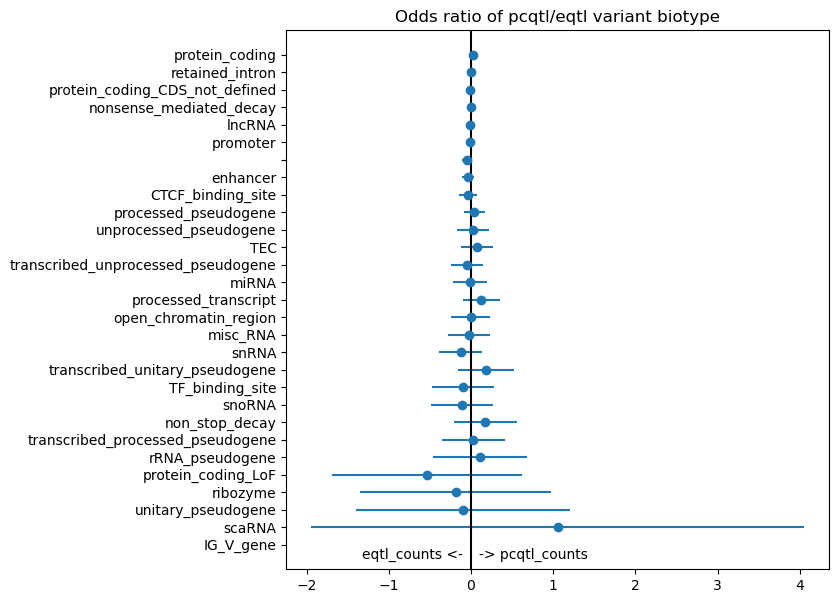

In [32]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']>0)], key_col='BIOTYPE')
eqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']==0)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant biotype', key_col='BIOTYPE')

<AxesSubplot: title={'center': 'Odds ratio of single egene vs multi egene eqtl variant biotype'}>

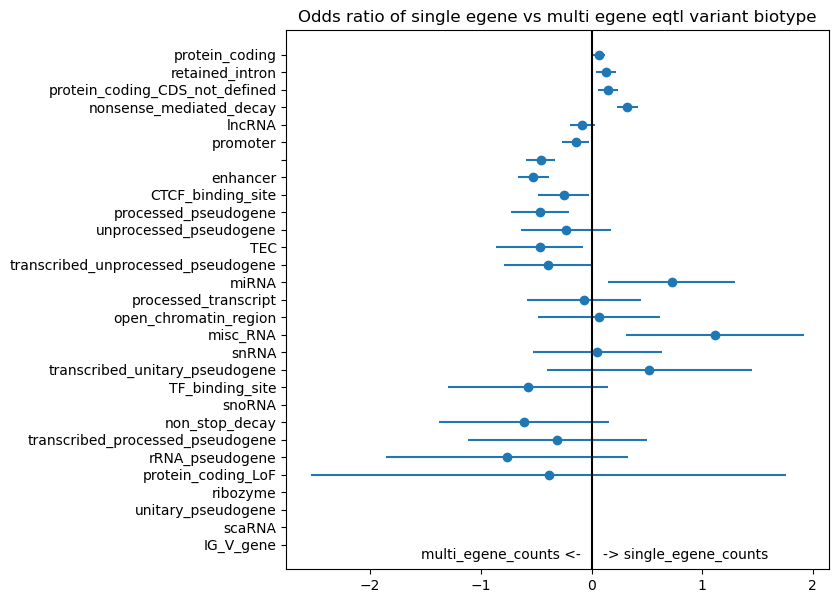

In [33]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

single_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)], key_col='BIOTYPE')
multi_egene_counts = get_or_counts(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)], key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(single_egene_counts, 'single_egene_counts', multi_egene_counts, 'multi_egene_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of single egene vs multi egene eqtl variant biotype', key_col='BIOTYPE')

<AxesSubplot: title={'center': 'Odds ratio of cluster pcqtls/all eqtls variant biotype'}>

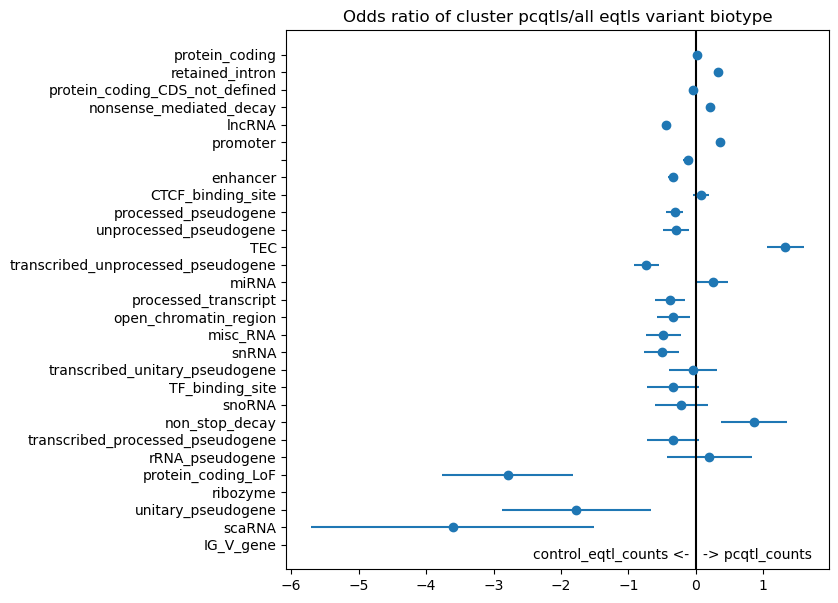

In [35]:
# vs control group
pcqtl_counts = get_or_counts(vep_df[(vep_df['pc_num']>0)], key_col='BIOTYPE')
control_counts = get_or_counts(control_vep_df, key_col='BIOTYPE')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', control_counts, 'control_eqtl_counts', ordered_categories=ordered_b_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of cluster pcqtls/all eqtls variant biotype', key_col='BIOTYPE')

### Transcription factors

In [36]:
# TFs are split with :: and &
def split_tfs(row):
    split_tfs = [indv_tf for tf in row['TRANSCRIPTION_FACTORS'] for indv_tf in tf.split('&')]
    split_tfs = [indv_tf for tf in split_tfs for indv_tf in tf.split('::')]
    return list(set(split_tfs))

vep_df['tf_set'] = vep_df.apply(split_tfs, axis=1)

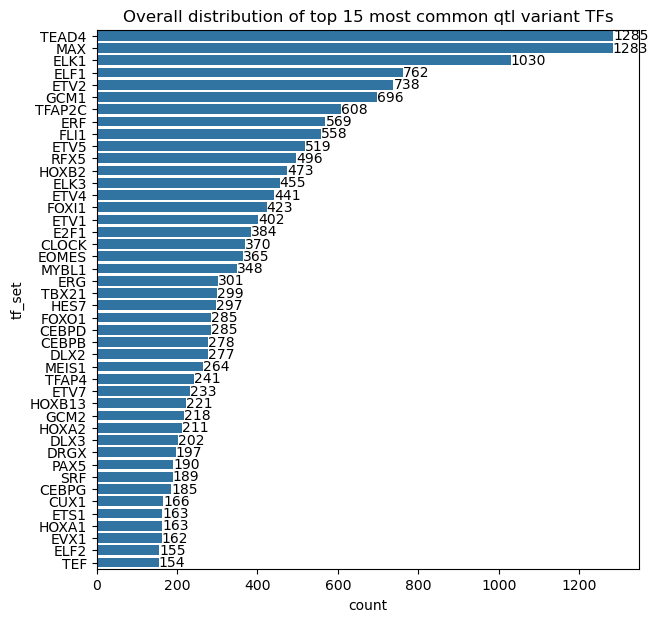

In [37]:
# overall distribution of transcription factors
fig, ax = plt.subplots(figsize=(7,7))
ordered_t_categories = vep_df.explode('tf_set')['tf_set'].value_counts().index
subsample_df = vep_df.explode('tf_set')
subsample_df = subsample_df[subsample_df['tf_set'].isin(ordered_t_categories[1:45])]
y = sns.countplot(subsample_df, y='tf_set', ax=ax, order=ordered_t_categories[1:45])
for i in range(len(y.containers)):
    labels = [str(int(v)) if v else '' for v in y.containers[i].datavalues]
    y.bar_label(y.containers[i], labels=labels)
plt.title('Overall distribution of top 15 most common qtl variant TFs')
plt.show()

<AxesSubplot: title={'center': 'Odds ratio of pcqtl/eqtl variant tf'}>

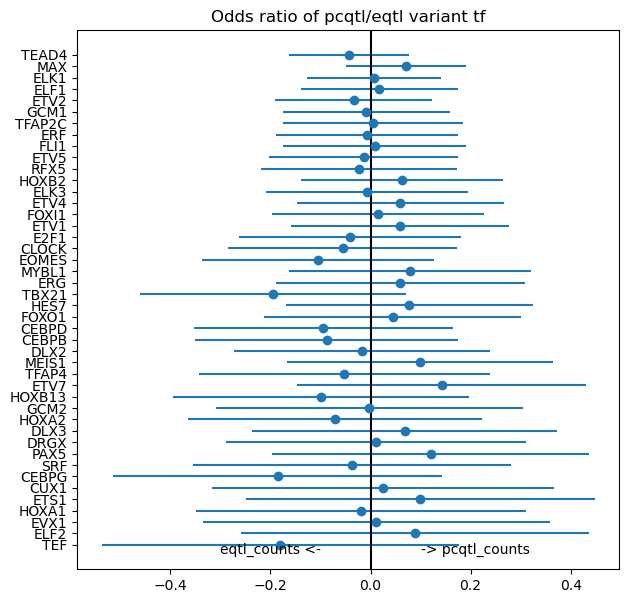

In [38]:
# basic pcqtl vs eqtl odds ratio
# get counts for all pcqtl svs all eqtls
pcqtl_counts = get_or_counts(subsample_df[(subsample_df['num_pc_samelead']>0)], key_col='tf_set')
eqtl_counts = get_or_counts(subsample_df[(subsample_df['num_e_samelead']>0)], key_col='tf_set')

# format into a df and get the error bars
or_df = get_odds_df(pcqtl_counts, 'pcqtl_counts', eqtl_counts, 'eqtl_counts', ordered_categories=ordered_t_categories)

# plot
plot_log_odds(or_df, 'Odds ratio of pcqtl/eqtl variant tf', key_col='tf_set')

## for presnetaitons

highlight a few interesting columns


**consequence**

NMD 

regulatory

TF binding

**biotype**

CTCF

enhancer

promotor

In [48]:
def selected_feature_or_df(df1, name1, df2, name2, features):
    # get biotype df
    df1_counts = get_or_counts(df1, key_col='BIOTYPE')
    df2_counts = get_or_counts(df2, key_col='BIOTYPE')

    # format into a df and get the error bars
    bio_or_df = get_odds_df(df1_counts, name1, df2_counts, name2 , ordered_categories=ordered_b_categories)

    # gert conseqeucne df
    df1_counts = get_or_counts(df1)
    df2_counts = get_or_counts(df2)

    # format into a df and get the error bars
    cons_or_df = get_odds_df(df1_counts, name1, df2_counts, name2, ordered_c_categories)

    # make into one df
    bio_or_df=bio_or_df.rename(columns={'BIOTYPE':'feature'})
    cons_or_df = cons_or_df.rename(columns={'consequence_set':'feature'})

    or_df = pd.concat([bio_or_df, cons_or_df])
    return or_df.set_index('feature').loc[features].reset_index()

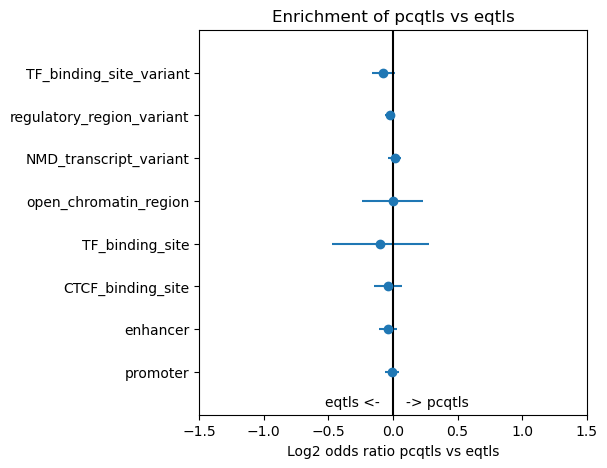

In [54]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[vep_df['pc_num']>0], 'pcqtls', vep_df[vep_df['pc_num']==0], 'eqtls', features)



fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio pcqtls vs eqtls')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


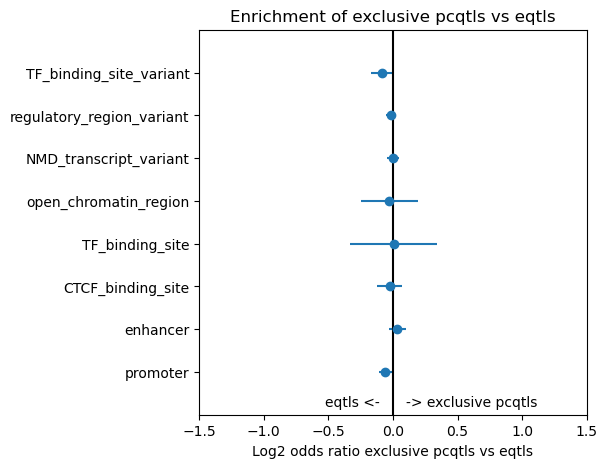

In [56]:

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
or_df = selected_feature_or_df(vep_df[(vep_df['pc_num']>0)& vep_df['num_e_overlap']==0], 'exclusive pcqtls', vep_df[vep_df['pc_num']==0], 'eqtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of exclusive pcqtls vs eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio exclusive pcqtls vs eqtls')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


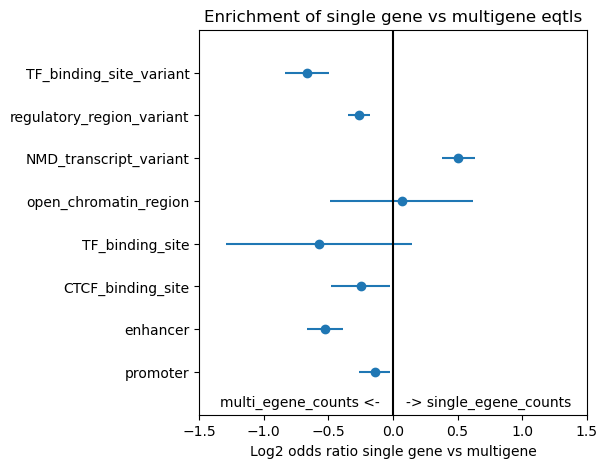

In [57]:
# get counts for all eqtls that were single gene vs eqtls that were multiple genes 

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']

or_df = selected_feature_or_df(vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']==1)], 'single_egene_counts', vep_df[(vep_df['pc_num'] ==0)&(vep_df['num_e_samelead']>1)], 'multi_egene_counts', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of single gene vs multigene eqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


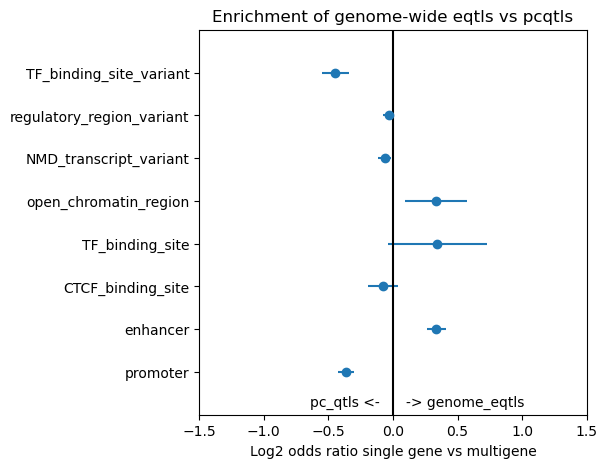

In [58]:
# get counts genome-wide eqtls vs pcqtls

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
# get counts for all eqtls vs pcqtls

or_df = selected_feature_or_df(control_vep_df, 'genome_eqtls', vep_df[vep_df['pc_num']>0], 'pc_qtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of genome-wide eqtls vs pcqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


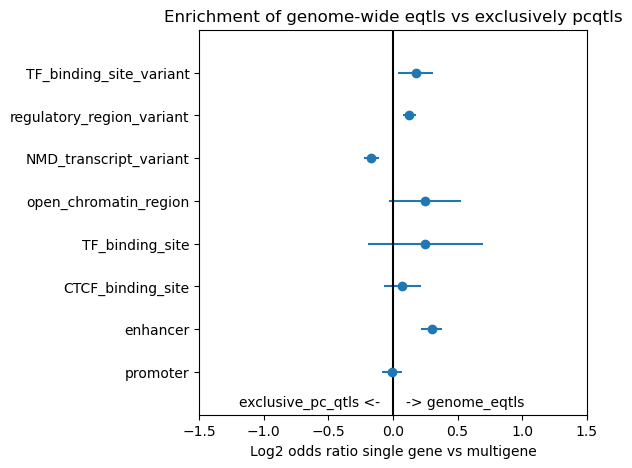

In [59]:
# get counts genome-wide eqtls vs exclusive pcqtls

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
# get counts for all eqtls vs pcqtls

or_df = selected_feature_or_df(control_vep_df, 'genome_eqtls', vep_df[(vep_df['num_pc_samelead']>0) & (vep_df['num_e_samelead']==0)], 'exclusive_pc_qtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of genome-wide eqtls vs exclusively pcqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


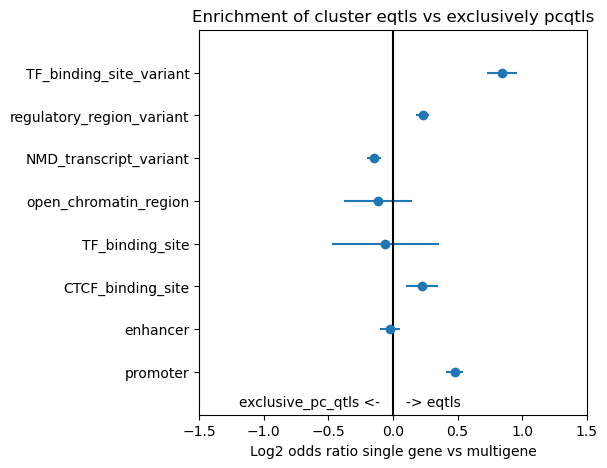

In [60]:
# get counts genome-wide eqtls vs exclusive pcqtls

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
# get counts for all eqtls vs pcqtls

or_df = selected_feature_or_df(vep_df[(vep_df['num_e_samelead']>0)], 'eqtls', vep_df[(vep_df['num_pc_samelead']>0) & (vep_df['num_e_samelead']==0)], 'exclusive_pc_qtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of cluster eqtls vs exclusively pcqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()


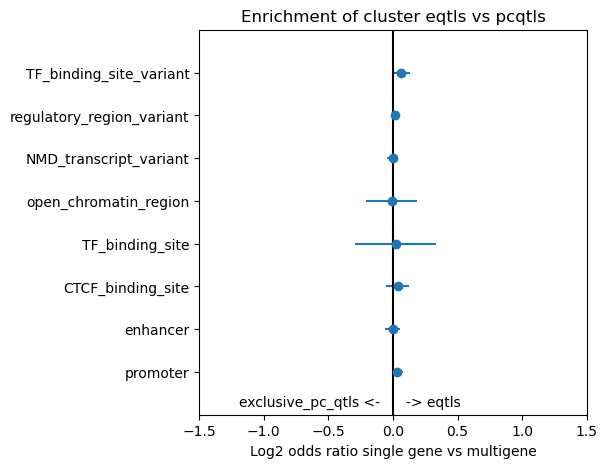

In [61]:
# get counts genome-wide eqtls vs exclusive pcqtls

features = ['promoter', 'enhancer', 'CTCF_binding_site', 'TF_binding_site', 'open_chromatin_region', 'NMD_transcript_variant', 'regulatory_region_variant', 'TF_binding_site_variant']
# get counts for all eqtls vs pcqtls

or_df = selected_feature_or_df(vep_df[(vep_df['num_e_samelead']>0)], 'eqtls', vep_df[(vep_df['num_pc_samelead']>0)], 'exclusive_pc_qtls', features)


fig, ax = plt.subplots(figsize=(5,5))
ax = plot_log_odds(or_df, 'Enrichment of cluster eqtls vs pcqtls', key_col='feature', ax=ax, offset=-8.8)
ax.set_xlabel('Log2 odds ratio single gene vs multigene')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1, 8)
plt.show()
